# One At the Time (OAT) Sensitivity analysis

This is the simplest case. Also called a _local_ Sensitivity analysis. One parameter is changed by keeping all the other constant and the difference in results is compared to the change. This allows to investigate how much results are affected by the specific change in the parameter. This is good for some types of analysis, but has some problems. Main issue is that the effect of a change in the parameter might be different when other parameters assume different values...so OAT can be misleading!  This problem can only be solved with a global sensitivity analysis (next notebook)

In [1]:
import brightway2 as bw
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
bw.projects.set_current('advlca23_simple_lca') # Still working in the same project
bw.databases

Databases dictionary with 6 object(s):
	biosphere3
	ecoinvent 3.8 conseq
	exldb
	sa_db
	testbiosphere
	testdb

In [3]:
#if 'sa_db' in bw.databases: del bw.databases['sa_db'] # to clean up if you do this multiple times
#bw.databases
method_key =  ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
database_name = 'ecoinvent 3.8 conseq'

In [4]:
SA_db = bw.Database('sa_db')

# A simplified db, one foreground activity: 'Electricity production,
# linked to a background one: 'market for electricity, low voltage' (kilowatt hour, DK, None)
SA_db.write({  
    ('sa_db', 'el_prod_for_sa'): {
        'name': 'Electricity production',
        'unit': 'kilowatt hour',
        'exchanges': [{
            'input': (database_name, '5b9673500c70699effae7f0d0c711c5f'), # Danish market for electricity
            'amount': 1,
            'type': 'technosphere'},
        {
            'input': ('sa_db', 'el_prod_for_sa'),
            'amount': 1,
            'type': 'production'}]}})

# select the foreground activity and calculate result
lca = bw.LCA({SA_db.get('el_prod_for_sa'): 1}, method_key)
lca.lci()
lca.lcia()
DK_result = lca.score
DK_result

Title: Writing activities to SQLite3 database:
  Started: 08/01/2023 13:40:08
  Finished: 08/01/2023 13:40:08
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 3.30


0.04259871016975952

# Changing the exchange kind

There are many ways of doing sensitivity analysis. One might for example be interested in changing the electricity mix (somebody might call this a _scenario analysis_...). For example, I would like to run my LCA with ten different market mixes in ecoinvent instead of just the Danish one.

In [5]:
# First make a list of processes we wants to change with, in this case el. markets
el_markets = [(database_name, i['code']) 
              for i in bw.Database(database_name).search('market electricity low voltage', limit = 100)]
el_markets[1:5] # prints the first four of them

[('ecoinvent 3.8 conseq', 'f5dad6d6b465099c79ce8d2e0a467c29'),
 ('ecoinvent 3.8 conseq', 'de92428ccbde5d8747554be66209d792'),
 ('ecoinvent 3.8 conseq', 'a290ca30a4bb2cd603d9695046d54f2e'),
 ('ecoinvent 3.8 conseq', '5065a586efff94e1a432b09fe41fa5ff')]

In [6]:
# Make a copy of the activity, substitute the background process, save and calculate
SA_el_loc_results = [] # empty list that will contain all the results of the local SA
el = SA_db.get('el_prod_for_sa')
for m in el_markets[0:20]: # I am just taking the first 20 of them to speed up
    el2 = el.copy() # implement the changes on a copy to keep the original intact
    exc = list(el2.exchanges())[0] # select the first exchange in the activity, i.e. the input from ecoinvent
    exc['input'] = m
    exc.save() # important or the changes won't be maintained
    lca = bw.LCA({el2: 1}, method_key)
    lca.lci()
    lca.lcia()
    SA_el_loc_results.append(lca.score)

In [7]:
SA_el_loc_results

[0.08512073466455493,
 0.0817796144046888,
 0.5155216206773505,
 0.08263631598942653,
 0.08310913889456682,
 0.08299765450003371,
 0.2496686354657466,
 0.13097800951224375,
 0.02090128574459293,
 0.5032502854942505,
 0.3663381830398216,
 0.3019892087513296,
 0.5455346994277829,
 0.5753874671953181,
 0.5370952041519821,
 0.4057506405997713,
 0.37855974241519125,
 0.5037985500363652,
 0.5256004720713056,
 0.5196915720354066]

In [8]:
# Unig numpy and pandas packages here
print(np.mean([(i/DK_result) for i in SA_el_loc_results])) # about 5.1 times higher impact than DK on average
pd.DataFrame(SA_el_loc_results).describe()

7.624302483790906


,0
count,20.000000
mean,0.324785
std,0.201891
min,0.020901
25%,0.084618
50%,0.372449
75%,0.516564
max,0.575387


Text(0.5, 0, 'El Production')

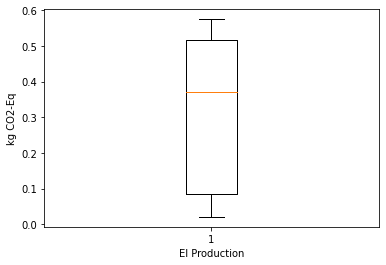

In [9]:
# Using matplotlib package
plt.boxplot(SA_el_loc_results)
plt.ylabel(bw.methods[method_key]['unit'])
plt.xlabel('El Production')

# Changing the exchange value

One might want to test different values for the same exchange, or see how results are affected by a percent change in the value of this exchange. Iin this case it's more handy to use _parametrized inventories_. There is a good [tutorial here](https://nbviewer.jupyter.org/urls/bitbucket.org/cmutel/brightway2/raw/default/notebooks/Parameters%20-%20manual%20creation.ipynb) about this that you can check it out, as well as some [theory here](https://docs.brightwaylca.org/intro.html#parameterized-datasets) on what type of parameters (activity-, database-, or project-parameters) one can define in brightway. Here we make just a simple example. 

## Without parameters

In [10]:
list(SA_db.get('el_prod_for_sa').exchanges())[0]

Exchange: 1 kilowatt hour 'market for electricity, low voltage' (kilowatt hour, DK, None) to 'Electricity production' (kilowatt hour, None, None)>

In [11]:
# the obvious solution is to use the same approach as above
SA_values = [1.01, 1.05, 1.1] # I am studying a change of 1%, 5%, 10% in the parameter
SA_el_value_results = []
el = SA_db.get('el_prod_for_sa')
for v in SA_values:
    el2 = el.copy()
    exc = list(el2.exchanges())[0]
    exc['amount'] = v # this is the different line compared to before
    exc.save()
    lca = bw.LCA({el2: 1}, method_key)
    lca.lci()
    lca.lcia()
    SA_el_value_results.append(lca.score)

In [12]:
SA_el_value_results

[0.04302469686528218, 0.04472864364706007, 0.04685858220244991]

Text(0.5, 0, 'SA values')

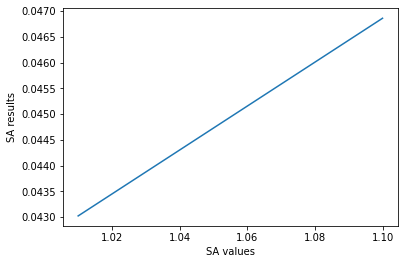

In [13]:
plt.plot(SA_values, SA_el_value_results)
plt.ylabel('SA results')
plt.xlabel('SA values')

In [14]:
(SA_el_value_results[0] - DK_result)/(1.01 - 1.) # Marginal change (slope of the line)

0.042598669552266315

In [15]:
from scipy import stats # just another way to do the same
slope, intercept, r_value, p_value, std_err = stats.linregress(SA_values, SA_el_value_results)
slope, intercept, r_value, p_value, std_err

(0.04259872781850019,
 -1.9063889480919194e-08,
 0.999999999999771,
 4.308735740764127e-07,
 2.8831441469874435e-08)

## Same but using parameters

In [16]:
print(bw.parameters) # you shuold have none

Parameters manager with 2 objects


In [17]:
# If you get a result like: "Parameters manager with 1 objects" then comment out and run this cell
#from bw2data.parameters import *

#for param in ActivityParameter.select(): 
#    print(param, param.amount) # This is to check what aprameters are in your notebook already

#del bw.databases['sa_db'] # delete the database to clean up existing Database and activity parameters
#bw.parameters.remove_from_group("my group", bw.Database('sa_db').get('el_prod_for_sa')) # also a way to clean up 

In [18]:
bw.parameters

Parameters manager with 2 objects

In [19]:
# Same product system as before but including a parameter
SA_db = bw.Database('sa_db')
SA_db.write({  
    ('sa_db', 'el_prod_for_sa'): {
        'name': 'Electricity production',
        'unit': 'kilowatt hour',
        'exchanges': [{
            'input': (database_name, '5b9673500c70699effae7f0d0c711c5f'), 
            'amount': 1.0,
            'type': 'technosphere',
            'formula': 'my_parameter'}, # I added a new line here with the parameter "my_parameter"
        {
            'input': ('sa_db', 'el_prod_for_sa'),
            'amount': 1.0,
            'type': 'production'}]}})

Title: Writing activities to SQLite3 database:
  Started: 08/01/2023 13:43:33
  Finished: 08/01/2023 13:43:33
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 4.50


In [20]:
# Define the details of the parameter 'my_parameter'
activity_data = [ {
    'name': 'my_parameter',
    'amount': 1.0,
    'database': 'sa_db',
    'code' : 'somecode'
}]

In [21]:
bw.parameters # still nothing

Parameters manager with 2 objects

In [22]:
# First register these parameters
from bw2data.parameters import *
parameters.new_activity_parameters(activity_data, "my group", overwrite=True) # add a group name for the parameters

for param in ActivityParameter.select():
    print(param, param.amount)

Activity parameter: my group:__dummy_09490e296bc8481c8a953dba8b6f2db9__ 0.0
Activity parameter: my group:my_parameter 1.0


Parameter Activation is in **two steps**

In [23]:
# 1) Need to declare which activities have exchanges with parameters
parameters.add_exchanges_to_group("my group", SA_db.get('el_prod_for_sa'))

# 2) Update the exchanges with the new parameter value
ActivityParameter.recalculate_exchanges("my group")

# check if it worked
for exc in SA_db.get('el_prod_for_sa').exchanges():
    print(exc.amount, exc.input, exc.output)

1.0 'market for electricity, low voltage' (kilowatt hour, DK, None) 'Electricity production' (kilowatt hour, None, None)
1.0 'Electricity production' (kilowatt hour, None, None) 'Electricity production' (kilowatt hour, None, None)


In [24]:
# This is how you change the value of a parameter
ActivityParameter.update(amount = 2.0).where(ActivityParameter.name == 'my_parameter').execute()

# Need to do this as well if you want to see the new value of the exchange (otherwise only the parameter changes)
ActivityParameter.recalculate_exchanges("my group")

# check if it worked
for exc in SA_db.get('el_prod_for_sa').exchanges():
    print(exc.amount, exc.input, exc.output)

2.0 'market for electricity, low voltage' (kilowatt hour, DK, None) 'Electricity production' (kilowatt hour, None, None)
1.0 'Electricity production' (kilowatt hour, None, None) 'Electricity production' (kilowatt hour, None, None)


In [25]:
# Now this can be done in a loop for a series of values
SA_values = [1.01, 1.05, 1.1]
SA_el_value_results = []
for v in SA_values:
    ActivityParameter.update(amount = v).where(ActivityParameter.name == 'my_parameter').execute() # key line
    ActivityParameter.recalculate_exchanges("my group")
    for exc in SA_db.get('el_prod_for_sa').exchanges():
        print(exc.amount, exc.input, exc.output)
    lca = bw.LCA({SA_db.get('el_prod_for_sa') : 1}, method_key)
    lca.lci()
    lca.lcia()
    SA_el_value_results.append(lca.score)

1.01 'market for electricity, low voltage' (kilowatt hour, DK, None) 'Electricity production' (kilowatt hour, None, None)
1.0 'Electricity production' (kilowatt hour, None, None) 'Electricity production' (kilowatt hour, None, None)


1.05 'market for electricity, low voltage' (kilowatt hour, DK, None) 'Electricity production' (kilowatt hour, None, None)
1.0 'Electricity production' (kilowatt hour, None, None) 'Electricity production' (kilowatt hour, None, None)
1.1 'market for electricity, low voltage' (kilowatt hour, DK, None) 'Electricity production' (kilowatt hour, None, None)
1.0 'Electricity production' (kilowatt hour, None, None) 'Electricity production' (kilowatt hour, None, None)


In [26]:
SA_values

[1.01, 1.05, 1.1]

In [27]:
SA_el_value_results

[0.04302469686520483, 0.0447286436469808, 0.04685858220236713]

Text(0.5, 0, 'SA values')

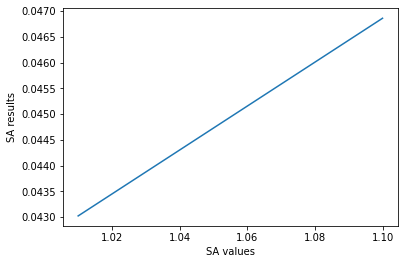

In [28]:
from matplotlib import pyplot as plt
plt.plot(SA_values, SA_el_value_results)
plt.ylabel('SA results')
plt.xlabel('SA values')

In [29]:
activity_name = 'market for electricity, low voltage'
# you can be much more specific in your search:
for activity in bw.Database(database_name).search(activity_name, filter={"location" : 'DE'}, limit = 5):
    print(activity)
    print(activity['code'])

Excluding 564 filtered results
'market for electricity, low voltage' (kilowatt hour, DE, None)
106e4e68f1a84151e19dc18303124441
'market for electricity, high voltage' (kilowatt hour, DE, None)
64e51f72cf75d4023d10003e874bbf93
'market for electricity, medium voltage' (kilowatt hour, DE, None)
5c23ea81ebef792c709b3d66479e1f79
'market for electricity, for reuse in municipal waste incineration only' (kilowatt hour, DE, None)
081498f01616e3f19c5e6331b2172354


One advantage of using parameters is that a parameter can be applied in multiple places in an inventory

In [30]:
SA_db = bw.Database('sa_db')
SA_db.write({  
    ('sa_db', 'el_prod_for_sa'): {
        'name': 'Electricity production',
        'unit': 'kilowatt hour',
        'exchanges': [{
            'input': (database_name, '5b9673500c70699effae7f0d0c711c5f'),  # Danish el market
            'amount': 0.5,
            'type': 'technosphere',
            'formula': 'my_parameter'}, # one parameter here 
        { 
            'input': (database_name, '106e4e68f1a84151e19dc18303124441'), # German el market
            'amount': 0.5,
            'type': 'technosphere',
            'formula': 'my_parameter'}, # the same parameter is also here
        {
            'input': ('sa_db', 'el_prod_for_sa'),
            'amount': 1,
            'type': 'production'}]}})

Title: Writing activities to SQLite3 database:
  Started: 08/01/2023 13:43:58
  Finished: 08/01/2023 13:43:58
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 4.65


In [31]:
lca = bw.LCA({SA_db.get('el_prod_for_sa') : 1}, method_key)
lca.lci()
lca.lcia()
print(lca.score)

0.08975543091174283


In [32]:
from bw2data.parameters import *

# define and register parameter
activity_data = [{
    'name': 'my_parameter',
    'amount': 1,
    'database': 'sa_db',
    'code' : 'somecode'}]

parameters.new_activity_parameters(activity_data, "my group", overwrite=True)

# activate parameter
parameters.add_exchanges_to_group("my group", SA_db.get('el_prod_for_sa')) # 1 step
ActivityParameter.recalculate_exchanges("my group") # 2 step

# Check if it worked
for param in ActivityParameter.select():
    print(param, param.amount)
for exc in SA_db.get('el_prod_for_sa').exchanges():
    print(exc.amount, exc.input, exc.output)

Activity parameter: my group:__dummy_09490e296bc8481c8a953dba8b6f2db9__ 0.0
Activity parameter: my group:my_parameter 1.0
1.0 'market for electricity, low voltage' (kilowatt hour, DK, None) 'Electricity production' (kilowatt hour, None, None)
1.0 'market for electricity, low voltage' (kilowatt hour, DE, None) 'Electricity production' (kilowatt hour, None, None)
1 'Electricity production' (kilowatt hour, None, None) 'Electricity production' (kilowatt hour, None, None)


In [34]:
# Same loop as before, this time the parameter changes in two places
SA_values = [0.5, 0.5*1.1, 0.5*0.9] # a change of plus/minus 10%
SA_el_value_results = []
for v in SA_values:
    ActivityParameter.update(amount = v).where(ActivityParameter.name == 'my_parameter').execute()
    ActivityParameter.recalculate_exchanges("my group")
    lca = bw.LCA({SA_db.get('el_prod_for_sa') : 1}, method_key)
    lca.lci()
    lca.lcia()
    SA_el_value_results.append(lca.score)
SA_el_value_results

[0.08975543091174283, 0.09873097614285258, 0.08077988568063216]

In [35]:
plus1 = ( SA_el_value_results[1] - SA_el_value_results[0] ) / SA_el_value_results[0]  
minus1 = ( SA_el_value_results[2] - SA_el_value_results[0] ) / SA_el_value_results[0]
plus1, minus1

(0.10000002384184933, -0.1000000238418597)

In [36]:
plus1 + minus1 # not exactly zero. Why?

-1.0366707492437399e-14

Text(0.5, 0, 'SA values')

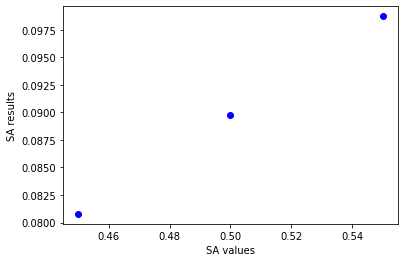

In [37]:
plt.plot(SA_values, SA_el_value_results, 'bo')
plt.ylabel('SA results')
plt.xlabel('SA values')